In [161]:
import scipy.integrate
import numpy
import matplotlib.pyplot
import os
import json
import scipy.interpolate

def dfdy(y,t,system):
    dfdy=system.M.dot(y)+system.u(t)
    return dfdy

def jacobi(y,t,system):
    return system.M

#SE post calculation
def dfdyS(S,t,system):
    #unwrap S to NxM where M is number of parameters
    mS=numpy.reshape(S,(system.n,system.m))
    mOut=system.M.dot(mS)+system.fS(t)
    return numpy.ravel(mOut)

def jacobiSE(S,t,system):
    N=system.n*(system.m)
    fJ=numpy.zeros((N,N))
    #print('fJ shape {}'.format(fJ.shape))
    for i in range(system.m):
        fJ[i*system.n:(i+1)*system.n,i*system.n:(i+1)*system.n]=system.M
    return fJ

#SE simultaeneous calculation
def dfdySFull(S,t,system):
    #unwrap S to NxM where M is number of parameters
    mS=numpy.reshape(S,(system.n,system.m+1))
    #system.fS(y,t) is NxM matrix where M are parameters
    y=mS[:,0]
    mOut=system.M.dot(mS)+system.fSY(y,t)
    return numpy.ravel(mOut)

def jacobiSEFull(S,t,system):
    N=system.n*(system.m+1)
    fJ=numpy.zeros((N,N))
    #print('fJ shape {}'.format(fJ.shape))
    for i in range(system.m+1):
        fJ[i*system.n:(i+1)*system.n,i*system.n:(i+1)*system.n]=system.M
    return fJ

class model:
    def __init__(self):
        self.compartments={}
        self.seJ={}
        
    def add_source(self,compartmentName,formula):
        self.compartments[compartmentName]['source']=formula

    def add_compartment(self,compartmentName):
        self.compartments[compartmentName]={}
        self.compartments[compartmentName]['targets']={}
        self.compartments[compartmentName]['sensTargets']={}

    def bind(self,sourceCompartment,targetCompartment,k,scaleToVolume=0):
        #establish a flow from one compartment to the other
        cSrc=self.compartments[sourceCompartment]
        cTarg=self.compartments[targetCompartment]
        vS=1
        vT=1
        if scaleToVolume:
            vS=self.mod["volumes"][sourceCompartment]
            vT=self.mod["volumes"][targetCompartment]
        
        #the source equation (where we subtract the current)
        addValue(cSrc['targets'],sourceCompartment,-k/vS)
        #the target equation (where we add the current)
        addValue(cTarg['targets'],sourceCompartment,k/vT)
                    
    def getDerivative(self,variable, source, target, q, pc, useVolume):
        v=1
        if useVolume:
            v=self.mod["volumes"][target]
        #the target equation (where we add the current)
        sign=1
        #the source equation (where we subtract the current)
        if source==target:
            sign=-1
            
        #for flow based transfer, k=Q/vS/pc, and jacobian derivative is -Q/V/pc/pc
        #for diffusion dominated transfer, k=k1/pc
        if variable=="partitionCoefficient":
            return sign*(-1)*q/v/pc/pc
        if variable=="diffusionCoefficient":
            return sign/pc/v
        if variable=="flow":
            return sign/pc/v
        if variable=="volume":
            return sign*(-1)*q/pc/v/v
            
    def bindDerivative(self,parameterName,variable,src,target,q,pc,useVolume=1):
        parName=parameterName
        if variable=="volume":
            parName='{}_V'.format(src)
        #the source equation (where we subtract the current)
        csrc=self.getSEJ_comp(parName,src)
        addValue(csrc,src,self.getDerivative(variable,src,src,q,pc,useVolume))
        
        if variable=="volume":
            parName='{}_V'.format(target)
        #the target equation (where we add the current)
        ctarget=self.getSEJ_comp(parName,target)
        addValue(ctarget,src,self.getDerivative(variable,src,target,q,pc,useVolume))
        
        
        
    def build(self):
        comps=self.compartments
        self.n=len(comps)
        self.M=numpy.zeros((self.n,self.n))
        self.fu=[lambda t:0]*self.n
        self.lut={c:i for (i,c) in zip(range(self.n),comps.keys())}
        for c in comps:
            comp=comps[c]
            if 'source' in comp:
                self.fu[self.lut[c]]=parseFunction(comp['source'])
                               
            for t in comp['targets']:
                self.M[self.lut[c],self.lut[t]]=comp['targets'][t]
        #build SE part
        self.m=len(self.seJ)
        #MxNxN matrix
        self.lutSE={c:i for (i,c) in zip(range(self.m),self.seJ.keys())}
        self.fSS=numpy.zeros((self.m,self.n,self.n))
        for par in self.seJ:
            sources=self.seJ[par]
            for compartment in sources:
                targets=sources[compartment]
                for t in targets:
                    #print('FSS: Adding {}/{},{}/{},{}/{}:{}'.\
                    #      format(par,self.lutSE[par],compartment,self.lut[compartment],t,self.lut[t],targets[t]))
                    self.fSS[self.lutSE[par],self.lut[compartment],self.lut[t]]=targets[t]
        
                      
        
        #print('Done')
    
    def inspect(self):
        comps=self.compartments
        print('Compartments')
        for c in comps:
            print('{}/{}:'.format(c,self.lut[c]))
            comp=comps[c]
            if 'source' in comp:
                print('\tsource\n\t\t{}'.format(comp['source']))
            print('\ttargets')
            for t in comp['targets']:
                print('\t\t{}[{},{}]: {}'.format(t,self.lut[c],self.lut[t],comp['targets'][t]))
        print('Flows')
        for f in self.flows:
            print('\t{}:{}'.format(f,self.flows[f]))
        print('SE parameters')
        for p in self.seJ:
            print(p)
            sources=self.seJ[p]
            for compartment in sources:
                targets=sources[compartment]
                for t in targets:
                    print('\t SE bind {}/{}:{}'.format(compartment,t,targets[t]))
        #print('Done')
    
    def parse(self,file):
                    
        with open(file,'r') as f:
            self.mod=json.load(f)
        for m in self.mod['compartments']:
            self.add_compartment(m)
        for s in self.mod['sources']:
            #src=mod['sources'][s]
            self.add_source(s,self.mod['sources'][s])
        self.flows={}
        for f in self.mod['flows']:
            if f.find(':')<0:
                continue
            comps=f.split(':')
            c0=splitVector(comps[0])
            c1=splitVector(comps[1])
            for x in c0:
                for y in c1:
                    pairName='{}:{}'.format(x,y)
                    self.flows[pairName]=f
                    
        parsSE=self.mod['sensitivityCalculation']['parameters']
        for b in self.mod['bindings']['diffusion']:
            comps=b.split('->')
            try:
                pc=self.mod['partitionCoefficients'][b]["value"]
            except KeyError:
                pc=1
            k1=self.mod['bindings']['diffusion'][b]
            self.bind(comps[0],comps[1],k1/pc)
            if "diffusions" in parsSE:
                self.bindDerivative(b,"diffusionParameter",comps[0],comps[1],k1,pc,0)
            if "partitionCoefficients" in parsSE:
                if b in self.mod['partitionCoefficients']:
                    parName='{}:PC'.format(b)
                    self.bindDerivative(parName,"partitionCoefficient",comps[0],comps[1],k1,pc,0)
            
        for q in self.mod['bindings']['flow']:
            comps=q.split('->')
            srcs=splitVector(comps[0])
            tgts=splitVector(comps[1])
            for cs in srcs:
                for ct in tgts:
                    try:
                        pc=self.mod['partitionCoefficients'][cs]
                    except KeyError:
                        pc=1
                    try:
                        qName=self.flows['{}:{}'.format(cs,ct)]
                    except KeyError:
                        qName=self.flows['{}:{}'.format(ct,cs)]
                    #convert to seconds
                    q=self.mod['flows'][qName]
                    try:
                        if self.mod['flows']['unit'].split('/')[1]=='min':
                            q/=60
                    except KeyError:
                        pass
                    self.bind(cs,ct,q/pc,1)
                    if "partitionCoefficients" in parsSE:
                        if cs in self.mod['partitionCoefficients']:
                             #associate parameter name in sensitivity table
                             parName=cs+'PC'
                             self.bindDerivative(parName,"partitionCoefficient",cs,ct,q,pc)
                    if "flows" in parsSE:
                        self.bindDerivative(qName,"flow",cs,ct,q,pc)
                    if "volumes" in parsSE:
                        self.bindDerivative("x","volume",cs,ct,q,pc)
                         
                    #print('bind: {}:(q={},vt={},pc={}):{}'.format(bind,q,vt,pc,q/vt/pc))
                
        self.build()
        
    def u(self,t):
        ub=[f(t) for f in self.fu]
        return numpy.array(ub)
                     
    def fSY(self,y,t):
        #M number of sensitivity parameters
        #N number of equations
        #fSS is MxNxN
        
        #assume a tabulated solution y(t) at t spaced intervals
        
        qS=self.fSS.dot(y)
        #qS is MxN
        #but NxM is expected, so do a transpose
        
        #for simultaneous calculation, a Nx(M+1) matrix is expected
        tS=numpy.zeros((self.n,self.m+1))
        #columns from 2..M+1 are the partial derivatives 
        tS[:,1:]=numpy.transpose(qS)
        #first column is the original function
        tS[:,0]=self.u(t)
        return tS
    
    def fS(self,t):
        #M number of sensitivity parameters
        #N number of equations
        #fSS is MxNxN
        
        #assume a tabulated solution y(t) at t spaced intervals
        
        qS=self.fSS.dot(self.getY(t))
        return numpy.transpose(qS)
                     
    def getSEJ(self,parName):
        #find the sensitivity (SE) derivative of Jacobi with respect to parameter  
        try:
            return self.seJ[parName]
        except KeyError:
            self.seJ[parName]={}
            return self.seJ[parName]
    
    def getSEJ_comp(self,parName,compartmentName):
        #find equation dictating concentration in compartmentName for jacobi-parameter derivative
        seJ=self.getSEJ(parName)
        
        try:
            return seJ[compartmentName]
        except KeyError:
            seJ[compartmentName]={}
            return seJ[compartmentName]
    def setY(self,t,y):
        self.tck=[None]*self.n
        for i in range(self.n):
            self.tck[i] = scipy.interpolate.splrep(t, y[:,i], s=0)
    
    def getY(self,t):
        fY=numpy.zeros(self.n)
        for i in range(self.n):
            fY[i]=scipy.interpolate.splev(t, self.tck[i], der=0)
        return fY
        
def splitVector(v):
    if v.find('(')<0:
        return [v]
    return v[1:-1].split(',')

def parseFunction(formula):
    if formula['name']=='exponential':
        c0=formula['constant']
        k=formula['k']
        return lambda t:c0*numpy.exp(k*t)
    if formula['name']=='constant':
        c0=formula['value']
        return lambda t:c0
    if formula['name']=='Heavyside':
        t0=formula['limit']
        v=formula['value']
        return lambda t:v if t<t0 else 0
    return lambda t:1

def addValue(qdict,compName,v):
    #add real number v to attribute compName of dictionary qdict, check if compName exists and handle the potential error
    try:
        qdict[compName]+=v
    except KeyError:
        qdict[compName]=v

                

In [163]:
sys=model()
fh=os.path.expanduser('~')
#sys.parse(os.path.join(fh,'software','src','Integra','models','cDiazepam.json'))
sys.parse(os.path.join(fh,'software','src','Integra','models','cCotinine.json'))
#print(sys.u(10)[sys.lut['venous']])
#sys.inspect()         
nt=1001
t = numpy.linspace(0, 4*3600, nt)
#first column is the solution y
#initial condition
y0=numpy.zeros(sys.n)
    
doSequential=0

if doSequential:
#sequential SE (first true solution, then parameter derivatives)
    y0=numpy.zeros(sys.n)
    sol = scipy.integrate.odeint(dfdy, y0, t, args=(sys,),Dfun=jacobi)
    sys.setY(t,sol)
    S0=numpy.zeros((sys.n,sys.m))
    S0=S0.ravel()
    #print('lut {}'.format(sys.lut))
    #print('lutSE {}'.format(sys.lutSE))
    #fJ=sys.fSS[sys.lutSE['brainPC']]
    #print('X shape {}\n {}'.format(fJ.shape,fJ))
    solSE=scipy.integrate.odeint(dfdyS, S0, t, args=(sys,),Dfun=jacobiSE)
    s1=numpy.reshape(solSE,(len(t),sys.n,sys.m))
    print('Done sequential SE')
    

else:
#simultaneous SE
    S1=numpy.zeros((sys.n,sys.m+1))
    #set initial condition
    S1[:,0]=y0
    S1=S1.ravel()
    solSE1=scipy.integrate.odeint(dfdySFull, S1, t, args=(sys,),Dfun=jacobiSEFull)
    sFull=numpy.reshape(solSE1,(len(t),sys.n,sys.m+1))
    s1=sFull[:,:,1:]
    sol=sFull[:,:,0]
    print('Done simultaneous SE')



Done simultaneous SE


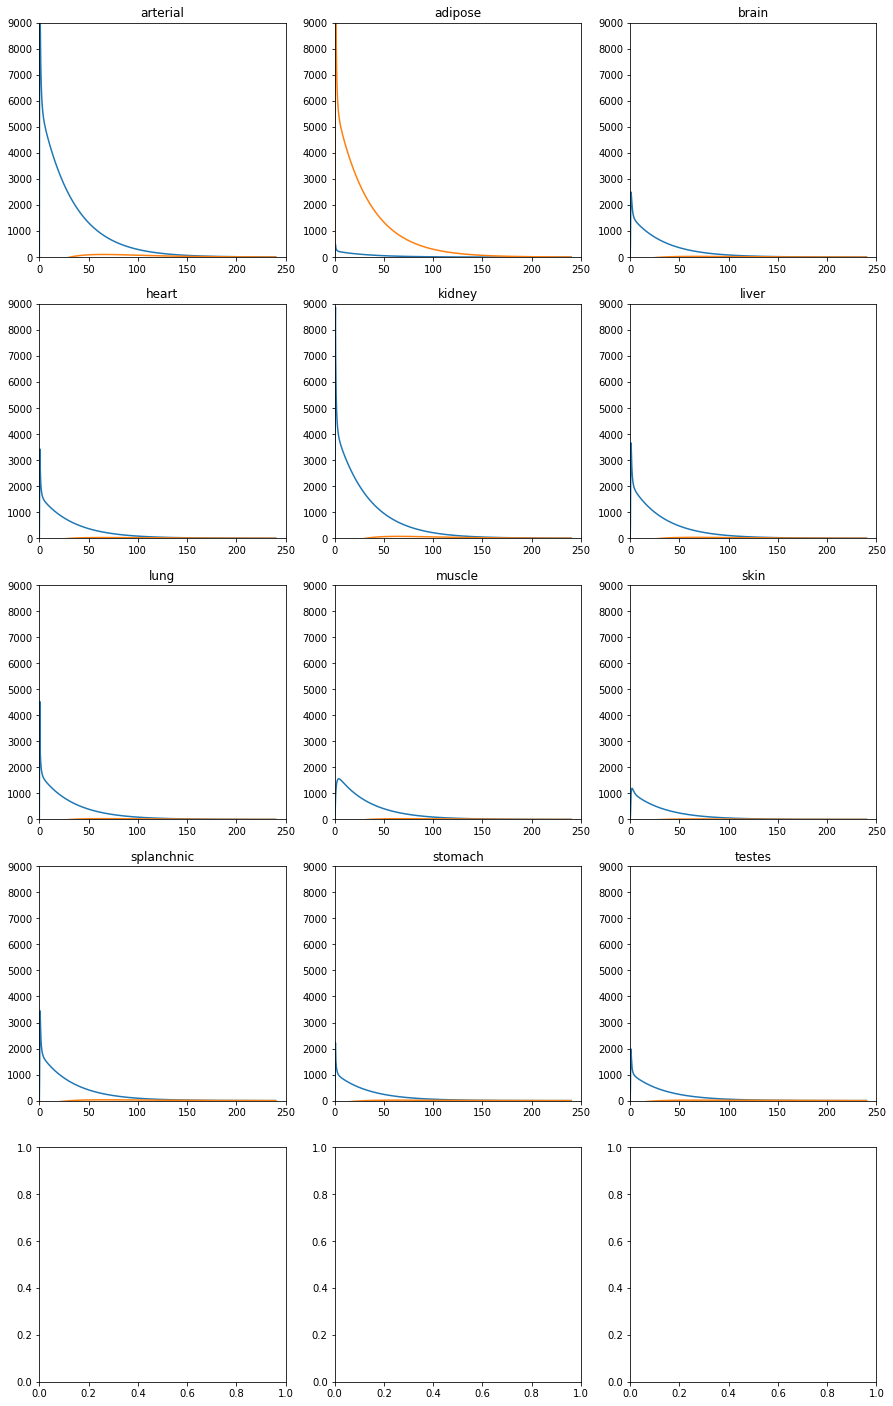

In [165]:
#copy output of Thompson et al
fig, axs = matplotlib.pyplot.subplots(5, 3,figsize=(15,25))
name=['arterial','adipose','brain','heart','kidney','liver','lung','muscle','skin',
      'splanchnic','stomach','testes']
#diazepam
max=[1.5,2.6,3,4,5,2.5,6.8,1.5,1.5,4,4.2,3]
#cotinine
max=[9]*12

max=[1000*x for x in max]
for i in range(len(name)):
    row=i//3
    col=i%3
    axs[row,col].plot(t/60,sol[:,sys.lut[name[i]]])
    axs[row,col].plot(t/60,s1[:,sys.lut[name[i]],0])
    axs[row,col].set_title(name[i])
    axs[row,col].set_ylim([0,max[i]])
    axs[row,col].set_xlim([0,250])


#### 422/(9.1/0.15)/60

In [80]:
import scipy.interpolate
x = numpy.arange(0, 2*numpy.pi+numpy.pi/4, 2*numpy.pi/8)
Y=numpy.zeros((len(x),2))
Y[:,0] = numpy.sin(x)
Y[:,1] = numpy.sin(x)

tck = scipy.interpolate.splrep(x, Y[:,0], s=0)





In [18]:
M=numpy.ones((3,2,2))
M[0,0,1]=2
M[1,1,0]=3
M[2,1,1]=5
v=numpy.ones(2)
q=M.dot(v)
q1=q.ravel()
q2=numpy.reshape(q1,q.shape)
print(q)
print(q2)

[[3. 2.]
 [2. 4.]
 [2. 6.]]
[[3. 2.]
 [2. 4.]
 [2. 6.]]
